In [158]:
using Gurobi, Cbc, Mosek, PyPlot, JuMP, Ipopt


## Tyre specs
coflo = 0.02 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.4 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)


## car specs all specs in meters and seconds
# mass = 1000 # in kg
g = 9.8  # gravitational pull in m/sec^2
maxacc = 6.5 # max acc in m/sec^2
maxv = 55.55 # max velocity in m/sec equivalent to 200km/hr
maxTu = 1.27 #max steer one side


##model
# m = Model(solver = IpoptSolver(print_level=0))
m = Model(solver = GurobiSolver())

## Start ad Finish constraints
k =50
startPos = [50,1]
finishPos = [550, 1]
startVel = [0,0]
finishVel = [0,0]
startAccDM = [0,maxacc]
finishAccDM = [0,0]

## Basic variables and their constraints
@variable(m, P[1:2,1:k])  # resulting position in x,y
@variable(m, v[1:2,1:k])
@variable(m, -maxacc <= Thrust[1:k] <= maxacc)  # thruster input
@variable(m, AccDM[1:2,1:k])
# @variable(m, AccDMBeta[1:k] >= 0)
# @variable(m, AccCent[1:2,1:k])
@constraint(m, P[:,1] .== startPos)
@constraint(m, v[:,1] .== startVel)
@constraint(m, AccDM[:,1] .== startAccDM)
# @constraint(m, v[:,k] .== finishVel)
# @constraint(m, AccDM[:,k] .== finishAccDM)
@expression(m, finishDistance, sum((P[i,k]-finishPos[i])^2 for i in 1:2))


## motion constraints
for t in 1:k
#     @NLconstraint(m, AccDM[1,t]*AccCent[1,t] + AccDM[2,t]*AccCent[2,t] == 0)
#     @constraint(m, (AccCent[1,t]^2)+(AccCent[2,t]^2) <= (cofla*g)^2)
    @constraint(m, ((AccDM[1,t]^2)+(AccDM[2,t]^2)) <= (Thrust[t] - (coflo*g))^2)
    @constraint(m, (v[1,t]^2)+(v[2,t]^2) <= maxv^2)
end

# for t in 2:k
#     @constraint(m, AccDM[:,t] .== AccDMBeta[t]*(P[:,t]-P[:,t-1]))
# end
# @constraint(m, AccDM[:,1] .== AccDMBeta[1]*[0,1])

for t in 1:k-1    
    @constraint(m, v[1,t+1] == v[1,t] + AccDM[1,t] )# + AccCent[1,t])
    @constraint(m, v[2,t+1] == v[2,t] + AccDM[2,t] )# + AccCent[2,t])  
    @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*(AccDM[1,t] ))# + AccCent[1,t])) 
    @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*(AccDM[2,t] ))# + AccCent[2,t]))     
end


# for t in 2:k-1
#     @expression(m, v1, v[:,t+1]-v[:,t])
#     @constraint(m, ((v1[2]*v[2,t]+v1[1]*v[1,t]))/((v1[1]^2+v[2]^2)*(v[1,t]^2+v[2,t]^2)) <= cos(maxTu))
# #     @NLconstraint(m, (atan(v[2,t]/v[1,t])-atan(v[2,t+1]/v[1,t+1])) >= -maxTu)
# end


## Track boundaries variables and constraints
@constraint(m, P[1,:] .<= 600)
@constraint(m, P[1,:] .>= 0)
# for t in 1:k
#     @constraint(m, (P[2,t] - 2000)^2 <= (300^2 - (300 - P[1,t])^2))
# #     @NLconstraint(m, (P[1,t]-2000)^2 + (P[2,t]- 300)^2 >= 200^2)
# end
for t in 1:30
    @constraint(m,P[1,t] <= 100)
end
for t in 30:40
    @constraint(m,P[2,t] >= 1200)
end
for t in 40:50
    @constraint(m,P[1,t] >= 500)
end


## Objective function
# @NLobjective(m, Min, finishDistance)
@objective(m, Min, finishDistance)
solve(m)



Academic license - for non-commercial use only
Optimize a model with 354 rows, 350 columns and 844 nonzeros
Model has 2 quadratic objective terms
Model has 100 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [4e-01, 4e-01]
  Objective range  [2e+00, 1e+03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [6e+00, 6e+00]
  RHS range        [1e+00, 1e+03]
  QRHS range       [4e-02, 3e+03]
Presolve removed 162 rows and 62 columns
Presolve time: 0.00s
Presolved: 291 rows, 386 columns, 766 nonzeros
Presolved model has 97 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 36
 AA' NZ     : 1.243e+03
 Factor NZ  : 3.038e+03
 Factor Ops : 3.560e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.12723344e+05 -1.27706598e+06  9.91e+02 9.1

:Optimal

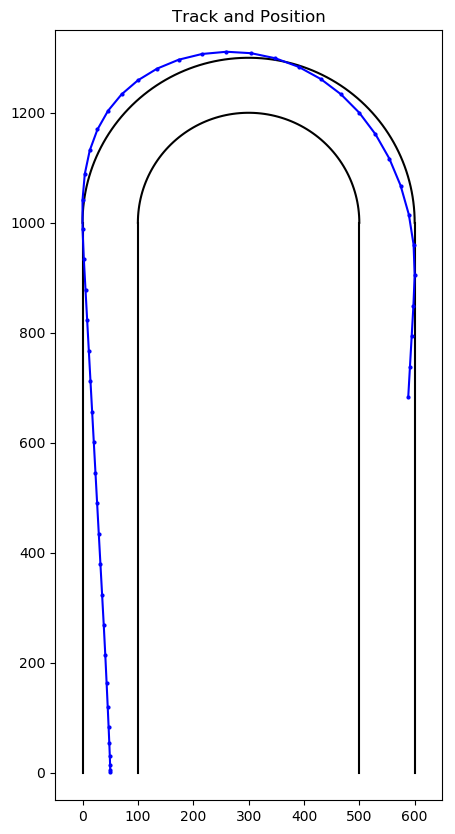

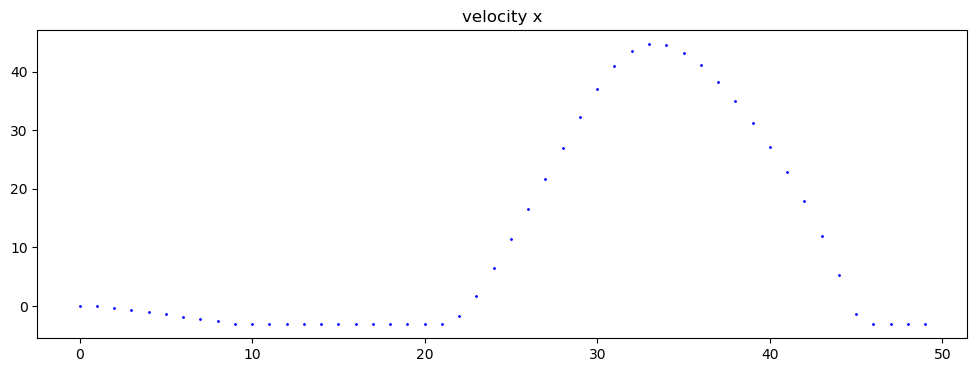

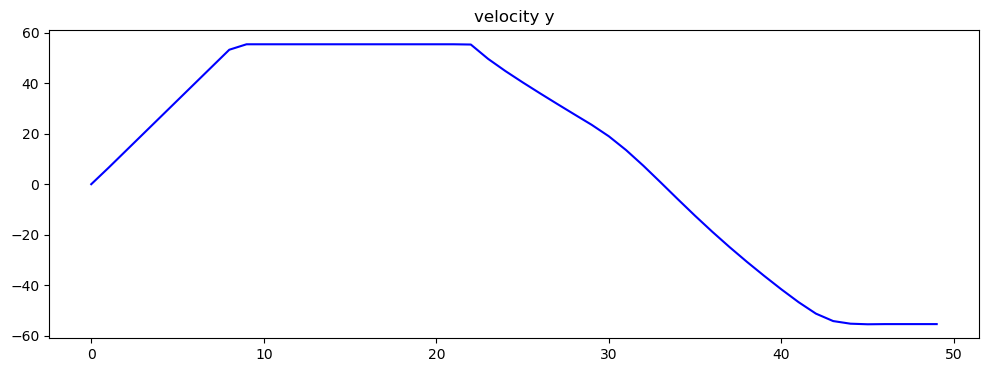

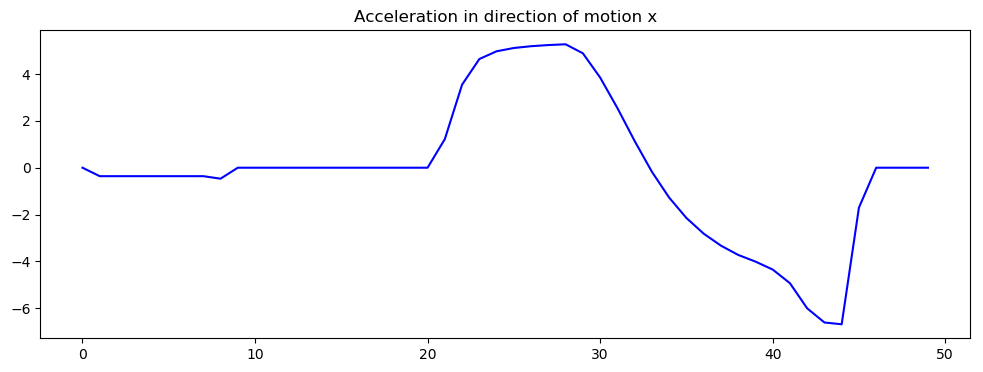

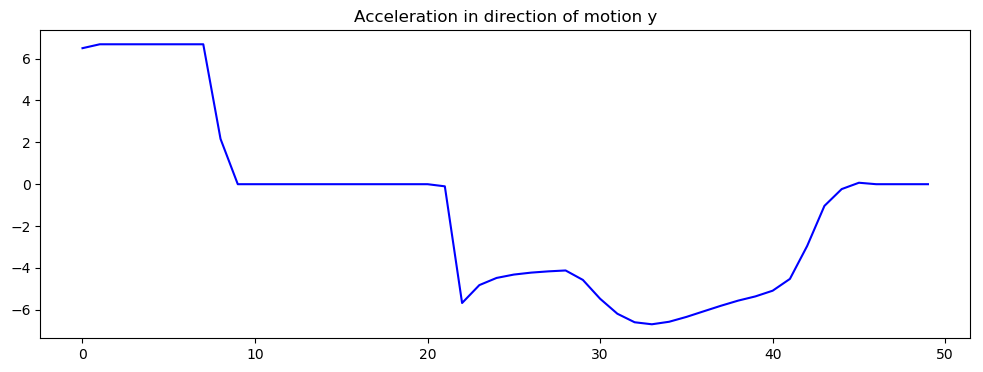

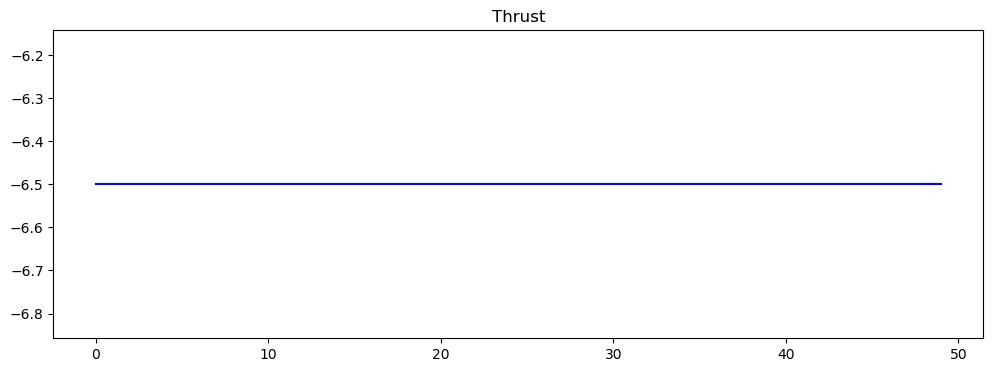

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14e2c6d10>

In [159]:
## Plotting everything
#Plotting track (Position plots will also go in same figure)
rad = linspace(0,π,100) 
x = 300 + 200*cos.(rad)
y = 1000 + 200*sin.(rad)
x1 = 300 + 300*cos.(rad)
y1 = 1000 + 300*sin.(rad)
Llinex = [0, 0]
Lliney = [0, 1000]
LMlinex = [100,100]
LMliney = [0,1000]
RMlinex = [500, 500]
RMliney = [0,1000]
Rlinex = [600,600]
Rliney = [0,1000]
figure(figsize=(5,10))
title("Track and Position")
#Track
plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )
#Position
plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 )
axis((-50,650,-50,1350));

figure(figsize=(12,4))
title("velocity x")
plot( getvalue(v[1,:]), "b.", markersize=2 )

figure(figsize=(12,4))
title("velocity y")
plot( getvalue(v[2,:]), "b-", markersize=2 )

figure(figsize=(12,4))
title("Acceleration in direction of motion x")
plot( getvalue(AccDM[1,:]), "b-", markersize=2 )

figure(figsize=(12,4))
title("Acceleration in direction of motion y")
plot( getvalue(AccDM[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion x")
# plot( getvalue(AccCent[1,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion y")
# plot( getvalue(AccCent[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("AccDMBeta")
# plot( getvalue(AccDMBeta), "b-", markersize=2 )

figure(figsize=(12,4))
title("Thrust")
plot( getvalue(Thrust), "b-", markersize=2 )
